In [6]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

from collections import defaultdict
from collections import Counter

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

In [7]:
df = pd.read_csv("summaries_train.csv")
df.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording'], dtype='object')

In [8]:
df['text_len'] = df['text'].apply(lambda x: len(x.split(' ')))
df.head()

,student_id,prompt_id,text,content,wording,text_len
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,61
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,52
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,235
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,25
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,206


In [9]:
print("Max Text Length: {}".format(max(df['text_len'])))
print("Min Text Length: {}".format(min(df['text_len'])))
print("Max Content Score: {}".format(max(df['content'])))
print("Max Wording Score: {}".format(max(df['wording'])))
print("Min Content Score: {}".format(min(df['content'])))
print("Min Wording Score: {}".format(min(df['wording'])))
print("Number of Unique Content Score: {}".format(len(df['content'].unique())))
print("Number of Unique Wording Score: {}".format(len(df['wording'].unique())))
print("Number of Text: {}".format(len(df["text"].unique())))
print(" ")
# to see if each student have one text
print("Number of unique student id: {}".format(len(df["student_id"].unique())))
# to see each prompt is unique
print("Number of unique prompt id: {}".format(len(df["prompt_id"].unique())))


Max Text Length: 651
Min Text Length: 22
Max Content Score: 3.90032610436019
Max Wording Score: 4.3106931513921
Min Content Score: -1.72985945253881
Min Wording Score: -1.96261379376134
Number of Unique Content Score: 1134
Number of Unique Wording Score: 1134
Number of Text: 7165
 
Number of unique student id: 7165
Number of unique prompt id: 4


In [10]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [11]:
df['text_clean'] = df['text'].apply(clean_text)
df.head()

,student_id,prompt_id,text,content,wording,text_len,text_clean
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,61,the third wave was an experimentto see how peo...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,52,they would rub it up with soda to make the sme...
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,235,in egypt there were many occupations and socia...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,25,the highest class was pharaohs these people we...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,206,the third wave developed rapidly because the ...


In [12]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['text_clean'] = df['text_clean'].apply(remove_stopwords)
df.head()

,student_id,prompt_id,text,content,wording,text_len,text_clean
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,61,third wave experimentto see people reacted new...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,52,would rub soda make smell go away wouldnt bad ...
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,235,egypt many occupations social classes involved...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,25,highest class pharaohs people godsthen highes...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,206,third wave developed rapidly students genuinl...


In [13]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [14]:
df['text_clean'] = df['text_clean'].apply(stemm_text)
df.head()

,student_id,prompt_id,text,content,wording,text_len,text_clean
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,61,third wave experimentto see peopl react new on...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,52,would rub soda make smell go away wouldnt bad ...
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,235,egypt mani occup social class involv daytoday ...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,25,highest class pharaoh peopl godsthen highest ...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,206,third wave develop rapid student genuin belie...


In [15]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [16]:
df['text_clean'] = df['text_clean'].apply(preprocess_data)
df.head()

,student_id,prompt_id,text,content,wording,text_len,text_clean
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,61,third wave experimentto see peopl react new on...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,52,would rub soda make smell go away wouldnt bad ...
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,235,egypt mani occup social class involv daytoday ...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,25,highest class pharaoh peopl godsthen highest ...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,206,third wave develop rapid student genuin belie...


In [17]:
x = df['text_clean']
y = df['content']

print(len(x), len(y))

7165 7165


In [18]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5373 5373
1792 1792


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
#vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,3), min_df=0.1, max_df=0.7, max_features=100)
vect.fit(x_train)

CountVectorizer()

In [20]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [21]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(x_train_dtm, y_train)
y_pred = model.predict(x_test_dtm)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error: 0.3584207436324808
Mean Absolute Error: 0.45688968323062273
R2 Score: 0.6805747211192688


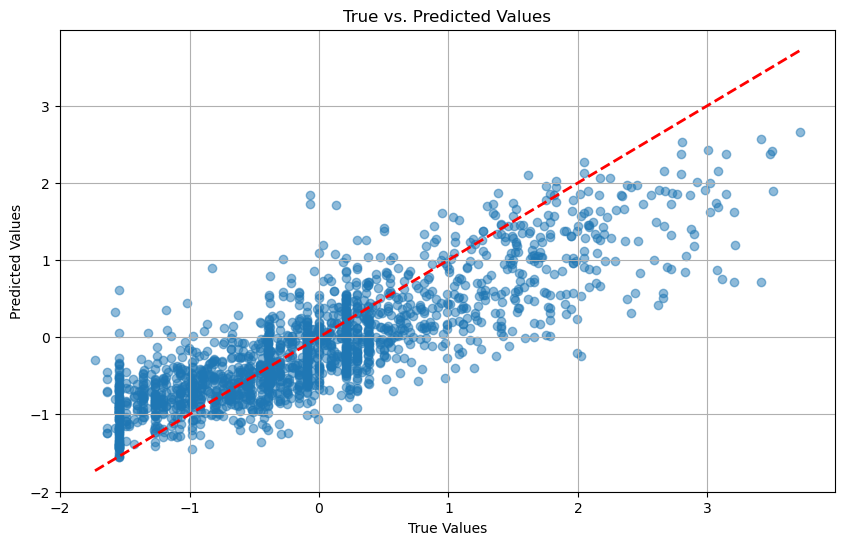

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=2, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.grid(True)
plt.show()


In [23]:
import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(x_train_dtm, y_train)
y_pred = model.predict(x_test_dtm)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error: 0.31784484071542385
Mean Absolute Error: 0.440422434677528
R2 Score: 0.7167360464202629


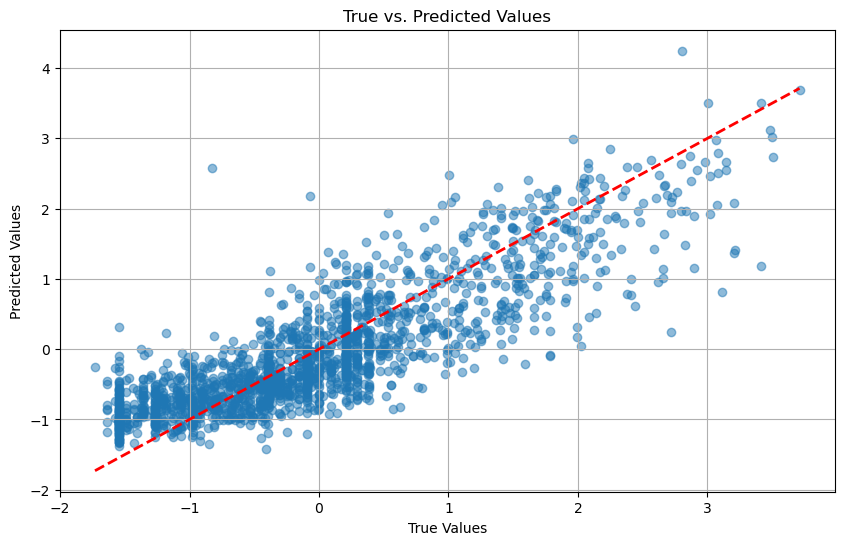

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=2, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.grid(True)
plt.show()


In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# how to define X and y for use with COUNTVECTORIZER
x = df['text_clean']
y = df['content']

# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

pipe = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBRegressor(
        use_label_encoder=False,
        eval_metric='auc',
    ))
])
from sklearn import metrics

# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

mse = mean_squared_error(y_test, y_pred_class)
mae = mean_absolute_error(y_test, y_pred_class)
r2 = r2_score(y_test, y_pred_class)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

5373 5373
1792 1792
Mean Squared Error: 0.2927276716331232
Mean Absolute Error: 0.423057759804328
R2 Score: 0.7391205174123634


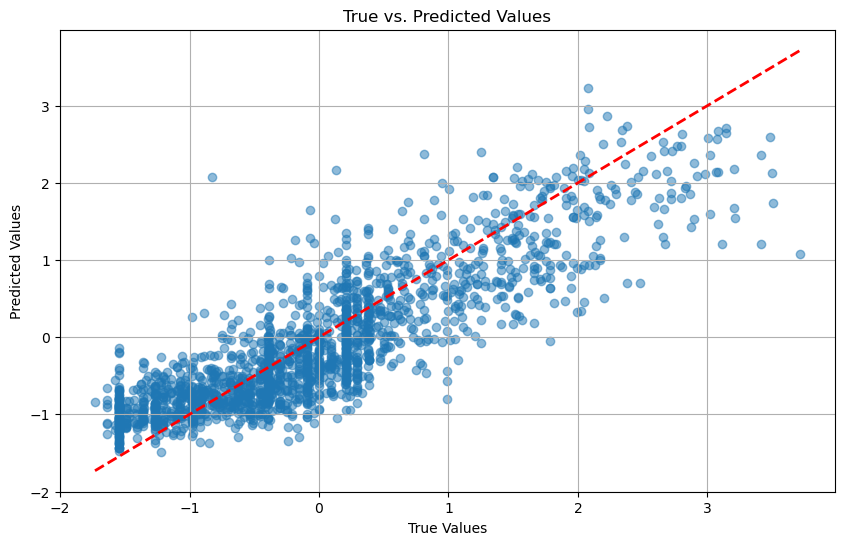

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_class, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=2, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.grid(True)
plt.show()


# BERT - Distilled Version

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [28]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)  # num_labels=1 for regression

# Preprocess your data
def encode_texts(texts):
    return tokenizer(texts, truncation=True, padding=True, return_tensors='tf', max_length=256)  # Reduced max_length for faster training

input_data = encode_texts(df["text_clean"].tolist())

# Convert tensor to numpy for train-test split
input_data_np = input_data['input_ids'].numpy()
labels = df["content"].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(input_data_np, labels, test_size=0.25)

# Fine-tune the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = tf.keras.metrics.MeanAbsoluteError()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [29]:
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.fit(X_train, y_train, epochs=3, batch_size=16)  # Increased batch size for faster training with DistilBERT

# Evaluate the model
results = model.evaluate(X_test, y_test)
print(f"Loss: {results[0]}, MAE: {results[1]}")

Epoch 1/3


2023-08-17 16:21:04.014645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


336/336 [==============================] - 628s 2s/step - loss: 0.3280 - mean_absolute_error: 0.4393
Epoch 2/3
336/336 [==============================] - 650s 2s/step - loss: 0.2345 - mean_absolute_error: 0.3710
Epoch 3/3
336/336 [==============================] - 660s 2s/step - loss: 0.1884 - mean_absolute_error: 0.3345


2023-08-17 16:53:20.822019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 57s 983ms/step - loss: 0.2425 - mean_absolute_error: 0.3819
Loss: 0.2425234317779541, MAE: 0.38194677233695984


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# After training the model...
y_pred = model.predict(X_test)

# Extracting the predictions from the output
predictions = y_pred[0].flatten()

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

56/56 [==============================] - 45s 815ms/step


In [33]:
# Print metrics
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Squared Error: 0.24252342322211715
Mean Absolute Error: 0.38194669946476273
R2 Score: 0.7864253064002753


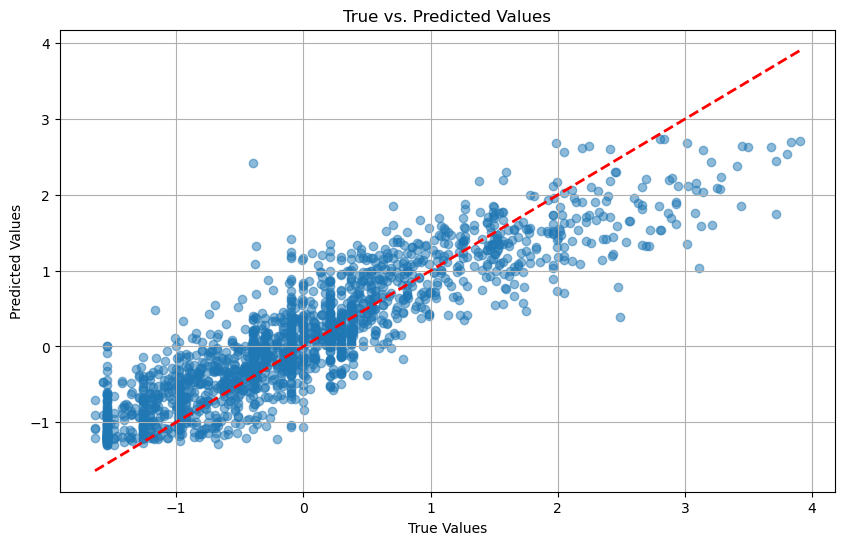

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=2, color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.grid(True)
plt.show()
